
Another try.

Using downsampled data (750,000 reads per sample)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Classify samples based on sample/subject prefix
def classify_sample(row):
    if row.name[0].startswith('CSE'): # or row['subject'].startswith('CSE'):
        return 'control'
    elif row.name[0].startswith('Blank'): # or row['subject'].startswith('Blank'):
        return 'blank'
    elif row.name[0].startswith('PLib'): # or row['subject'].startswith('PLib'):
        return 'phage_library'
    else:
        return 'subject'

# Classify samples based on sample/subject prefix
# Not sure if or how I'll use this
def add_lane(row):
    if row.name[7] in ['1','13']:
        return "L1"
    elif row.name[7] in ['2','14']:
        return "L2"
    elif row.name[7] in ['3','4']:
        return "L3"
    elif row.name[7] in ['5','6']:
        return "L4"
    elif row.name[7] in ['15','16']:
        return "L5"
    elif row.name[7] in ['17','18']:
        return "L6"
    else:
        return "L0"

In [3]:
from sklearn.decomposition import PCA

#def plot_pca(data_annot, manifest, title):
def plot_pca(local, title, min=0.1, max=99.9, size=10):
    # Remove annotation columns
    #X = local.drop(['plate', 'class'], axis=1).values
    X = local.values
    #y = local['class'].values
    y = local.index.get_level_values('class').values
    #plates = df['plate'].values
    plates = local.index.get_level_values('plate')
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))

    # ignore 0.2% of the points in the plot (there is a single very, very stray point in the combat plot)
    x_min, x_max = np.percentile(X_pca[:, 0], [min, max])
    y_min, y_max = np.percentile(X_pca[:, 1], [min, max])
    
    # https://mokole.com/palette.html
    custom_colors = [
        "#2f4f4f",
        "#228b22",
        "#7f0000",
        "#00008b",
        "#ff8c00",
        "#ffff00",
        "#00ff00",
        "#00ffff",
        "#ff00ff",
        "#1e90ff",
        "#eee8aa"  #,        "#ff69b4"
    ]
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=plates, style=y, s=size, palette=custom_colors)
    
    if min != 0:
        plt.xlim(xmin=x_min)
        plt.ylim(ymin=y_min)
    if max != 100:
        plt.xlim(xmax=x_max)
        plt.ylim(ymax=y_max)

    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [4]:
def plot_total_counts(local, title):
    # Calculate total counts per sample
    total_counts = local.sum(axis='columns')
    plot_df = pd.DataFrame({
        'total_counts': total_counts,
        'plate': local.index.get_level_values('plate'),
        'class': local.index.get_level_values('class')
    })
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='plate', y='total_counts', hue='class', data=plot_df, showfliers=False)
    plt.title(title)
    plt.ylabel('Total Counts per Sample')
    plt.xlabel('Plate')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [5]:
%%time

# Given the duplicated sample ids, MUST use Counts.csv and not data.csv/manifest.csv

# Load the manifest (sample metadata)
zscores = pd.read_csv('Zscores.manifest.csv',
			skipinitialspace=True,
			sep=",",
			header=list(range(10)),
			index_col=list(range(2)))

zscores.columns.names = ['sample','subject','path','type','study','group','age','sex','plate','lane'] #,class

print(f"zscores shape: {zscores.shape}")

zscores = zscores.drop('4', axis='columns', level='plate')

# Low counts. Less than 750,000
zscores = zscores.drop(
    columns=zscores.columns[zscores.columns.get_level_values('sample').isin(
        ['1310dup','Blank61dup','002699','PLib18dup','23565','C661MAA','961440dup','23339','Blank24dup','D069698dup'])]
        , axis='columns')


# Duplicated samples from other plates. 
zscores = zscores.drop(
    columns=zscores.columns[(
        (zscores.columns.get_level_values('subject').isin(['D082062','E045528'])
         ) & (
        zscores.columns.get_level_values('plate').isin(['15','16']))
    ) ] , axis='columns')

# THIS NEEDS
#['D082062', 'D082062dup', 'E045528', 'E045528dup']


# Low counts likely removed during processing, however remove them here too just in case.
zscores = zscores.drop(
    columns=zscores.columns[zscores.columns.get_level_values('sample').isin(
        ['D069698dup','Blank50_1','Blank03_2','Blank24dup'])]
        , axis='columns')

# Somehow I missed this sample? Has only 133828?
zscores = zscores.drop(
    columns=zscores.columns[zscores.columns.get_level_values('sample').isin(
        ['B002699'])]
        , axis='columns')

zscores = zscores.droplevel(level='path', axis='columns')

zscores.index.names = ['peptide','species']
zscores = zscores.droplevel(level='species', axis='index')


zscores = zscores.fillna(0).T

zscores['class'] = zscores.apply(classify_sample, axis='columns')
#zscores['lane'] = counts.apply(add_lane, axis='columns')
zscores.set_index('class', append=True, inplace=True)
#zscores.set_index('lane', append=True, inplace=True)

level_names = zscores.index.names

zscores.index = pd.MultiIndex.from_tuples([
    tuple('' if 'Unnamed' in str(level) else level for level in col)
    for col in zscores.index
], names=level_names)


print(f"zscores shape: {zscores.shape}\n")

zscores.head()

zscores shape: (115142, 1056)
zscores shape: (956, 115142)

CPU times: user 12.7 s, sys: 3.34 s, total: 16.1 s
Wall time: 16.1 s


,,,,,,,,,peptide,1,2,3,4,5,6,7,8,9,10,...,128278,128279,128280,128281,128282,128283,128284,128285,128286,128287
sample,subject,type,study,group,age,sex,plate,lane,class,,,,,,,,,,,,,,,,,,,,,
14078-01,14078-01,glioma serum,IPS,case,60,M,1,L1,subject,0.0,0.000000,0.0,0.0,0.0,0.0,1.283879,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.058819
14078-01dup,14078-01,glioma serum,IPS,case,60,M,1,L1,subject,0.0,8.048098,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,6.176605,0.0,0.0,1.734735,13.309234,0.682508,0.0,0.0,0.000000,0.000000
14118-01,14118-01,glioma serum,IPS,case,61,M,1,L1,subject,0.0,0.000000,0.0,0.0,0.0,0.0,20.939512,0.0,0.0,0.0,...,3.048855,0.0,0.0,5.520865,0.000000,0.000000,0.0,0.0,0.000000,0.000000
14118-01dup,14118-01,glioma serum,IPS,case,61,M,1,L1,subject,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.187553,0.000000
14127-01,14127-01,glioma serum,IPS,case,63,M,1,L1,subject,0.0,44.929438,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,3.849749,0.0,0.0,0.000000,10.729860,0.000000,0.0,0.0,0.000000,0.000000


In [6]:
zscores.loc[(zscores.index.get_level_values('type') == 'commercial serum control'),:]

,,,,,,,,,peptide,1,2,3,4,5,6,7,8,9,10,...,128278,128279,128280,128281,128282,128283,128284,128285,128286,128287
sample,subject,type,study,group,age,sex,plate,lane,class,,,,,,,,,,,,,,,,,,,,,
CSE01_1,CSE01,commercial serum control,,,,,1,L1,control,0.0,0.000000,0.0,0.000000,28.944102,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068844
CSE01_2,CSE01,commercial serum control,,,,,1,L1,control,0.0,0.000000,0.0,0.000000,35.375649,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,352.035115,0.000000,0.000000,0.000000,0.000000,0.000000
CSE02_1,CSE02,commercial serum control,,,,,2,L2,control,0.0,2.818944,0.0,0.000000,80.918118,0.0,0.649356,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.592222,0.000000,0.000000,0.000000,0.000000,0.000000
CSE02_2,CSE02,commercial serum control,,,,,2,L2,control,0.0,0.345707,0.0,0.000000,64.044460,0.0,0.000000,0.000000,0.0,1.757596,...,0.000000,0.000000,0.000000,0.177961,0.000000,1.722022,0.000000,0.000000,0.000000,0.209163
CSE03,CSE03,commercial serum control,,,,,3,L3,control,0.0,0.519139,0.0,3.650174,86.829061,0.0,0.000000,0.330428,0.0,0.000000,...,0.937436,0.000000,0.000000,1.296781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CSE03dup,CSE03,commercial serum control,,,,,3,L3,control,0.0,0.000000,0.0,3.125049,116.930102,0.0,1.195164,0.202549,0.0,0.000000,...,0.000000,0.000000,0.000000,0.500076,0.000000,0.000000,0.000000,0.000000,1.842989,0.000000
CSE05,CSE05,commercial serum control,,,,,5,L4,control,0.0,0.000000,0.0,0.000000,47.524463,0.0,0.000000,0.000000,0.0,1.604787,...,0.000000,0.168277,0.000000,2.149025,0.000000,0.000000,0.567205,2.597935,0.764937,0.000000
CSE05dup,CSE05,commercial serum control,,,,,5,L4,control,0.0,0.051340,0.0,0.000000,40.492856,0.0,1.961667,0.000000,0.0,0.000000,...,0.000000,0.000000,0.051340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CSE06,CSE06,commercial serum control,,,,,6,L4,control,0.0,0.000000,0.0,0.000000,99.818135,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.433482,0.313785,0.000000,1.987760,0.000000,0.000000,1.259668,0.000000


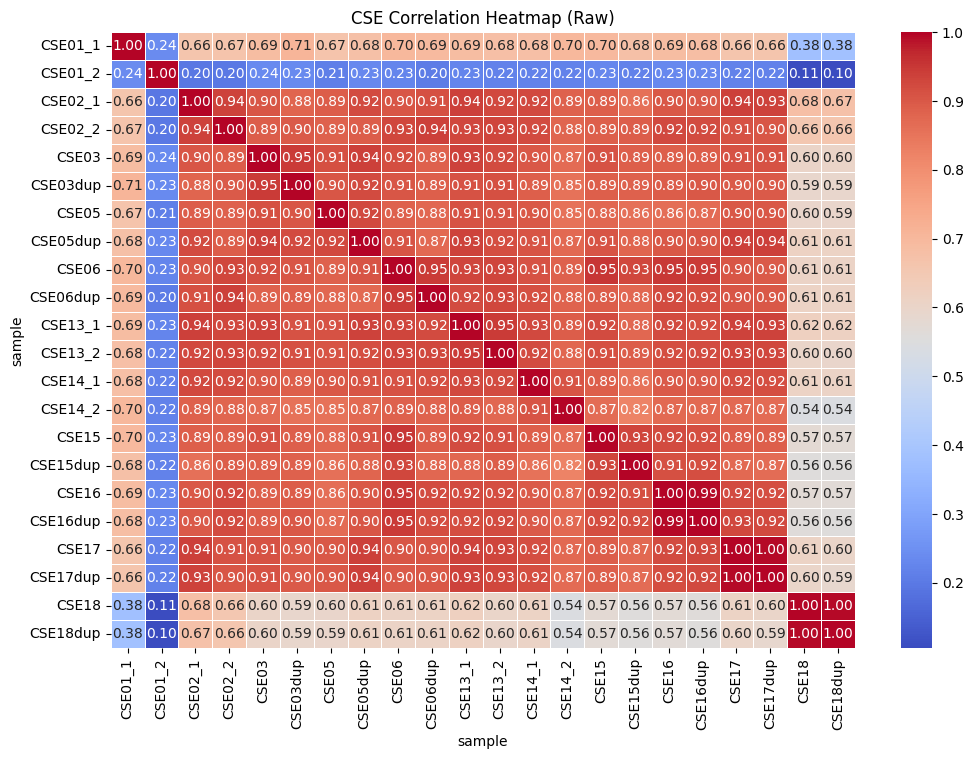

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    zscores.loc[
        (zscores.index.get_level_values('type') == 'commercial serum control'),:
        ].droplevel(level=list(range(1, 10))).T.corr()
    , annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('CSE Correlation Heatmap (Raw)')
plt.show()

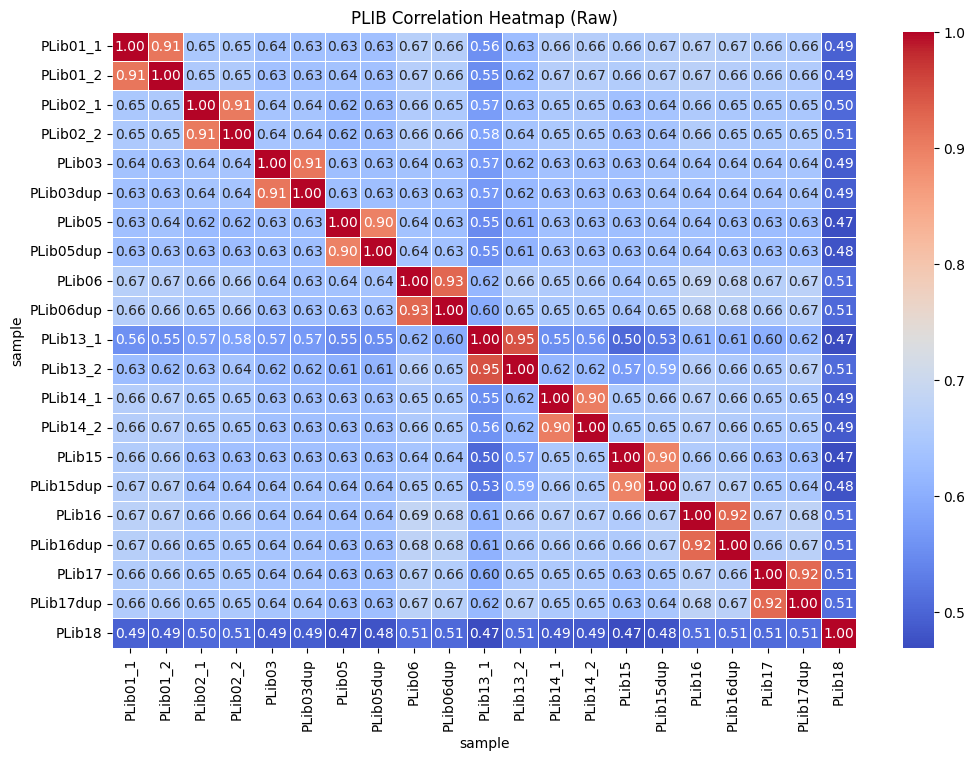

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    zscores.loc[
        (zscores.index.get_level_values('type') == 'Phage Library'),:
        ].droplevel(level=list(range(1, 10))).T.corr()
    , annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('PLIB Correlation Heatmap (Raw)')
plt.show()

# REMOVE A HUGE NUMBER OF "NOISY" PEPTIDES

# Keep peptides with more than 10% of samples having zscore > 20


In [9]:
# Option A: Keep peptides with signal above background in multiple samples
#min_samples = int(np.ceil(0.1 * zscores.shape[0])) # 10% of samples
#threshold = 5  # threshold for "detected"

# Option B: More stringent - require higher signal in fewer samples
# peptides_with_signal = (rpm_bgsub > 10).sum(axis=0) >= 5
# rpm_clean = rpm_bgsub.loc[:, peptides_with_signal]




min_samples = int(np.ceil(0.1 * zscores.shape[0])) # 10% of samples
threshold = 20  #

# Keep peptides with more than 10% of samples having zscore > 20

peptides_with_signal = (zscores > threshold).sum(axis=0) >= min_samples
zscores_clean = zscores.loc[:, peptides_with_signal]

print(f"Peptides after noise filter: {zscores_clean.shape[1]}")
print(f"Peptides removed as noise: {zscores.shape[1] - zscores_clean.shape[1]}")

Peptides after noise filter: 1219
Peptides removed as noise: 113923


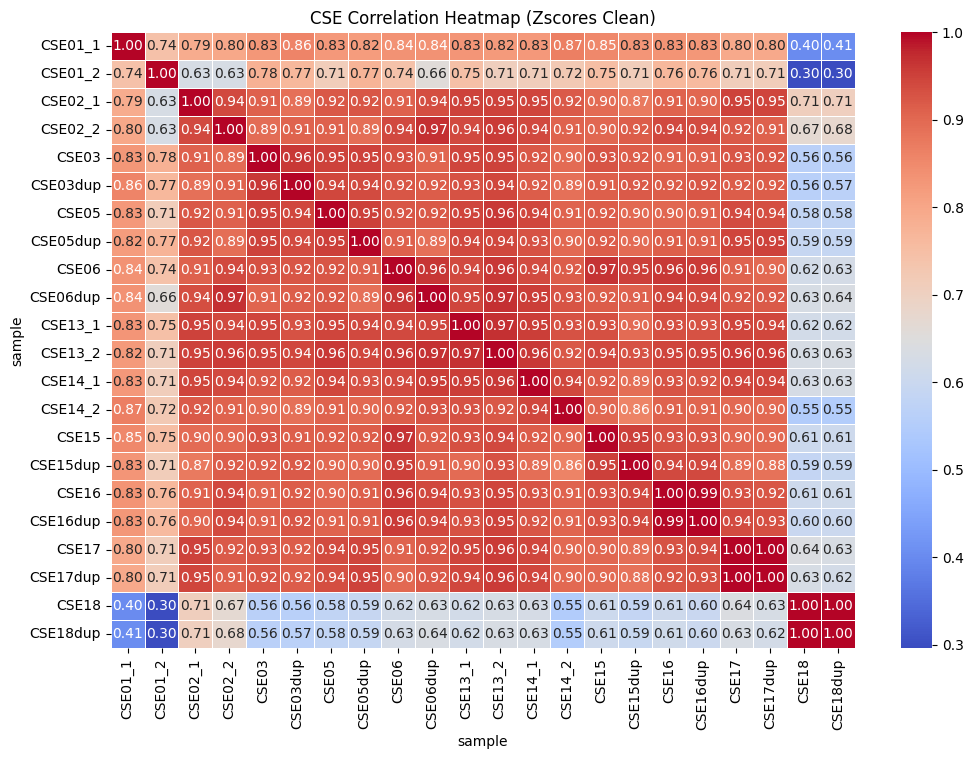

In [10]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    zscores_clean.loc[
        (zscores_clean.index.get_level_values('type') == 'commercial serum control'),:
        ].droplevel(level=list(range(1, 10))).T.corr()
    , annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('CSE Correlation Heatmap (Zscores Clean)')
plt.show()

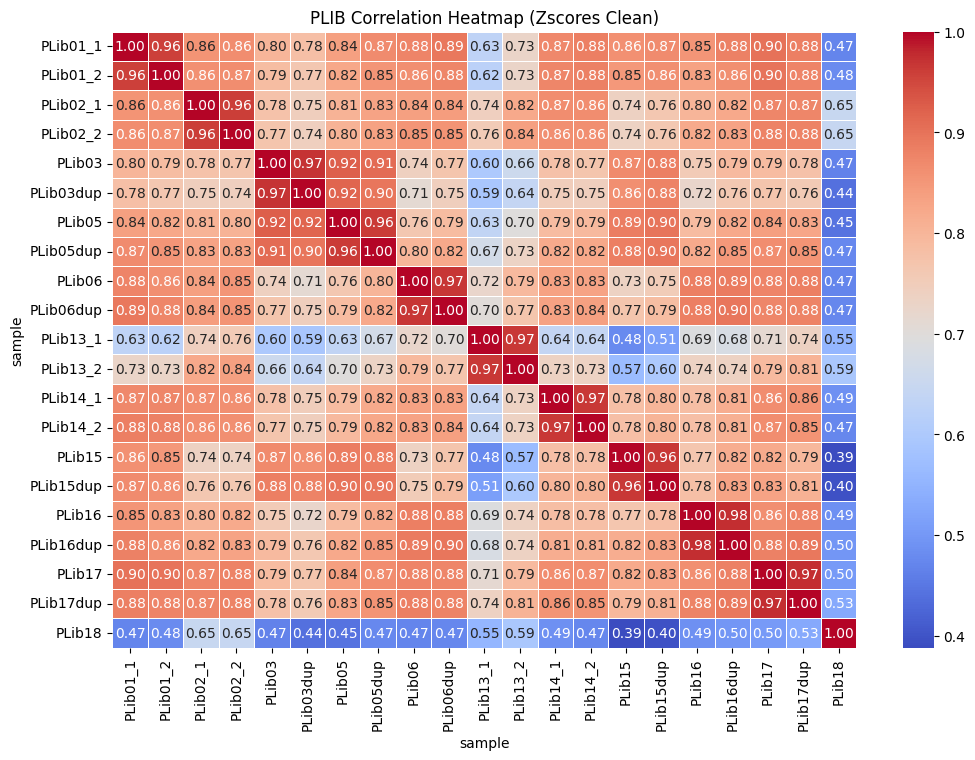

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    zscores_clean.loc[
        (zscores_clean.index.get_level_values('type') == 'Phage Library'),:
        ].droplevel(level=list(range(1, 10))).T.corr()
    , annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('PLIB Correlation Heatmap (Zscores Clean)')
plt.show()

In [12]:
# Don't do this. WAY TOO DENSE TO BE OF ANY USE.

#plt.figure(figsize=(12, 8))
#sns.heatmap(
#    zscores_clean.droplevel(level=list(range(1, 10))).T.corr()
#    , annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
#plt.title('Correlation Heatmap (Zscores Clean)')
#plt.show()